In [33]:
from matplotlib import pyplot as plt
import pandas as pd
import sys
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
sys.path.insert(0,"/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
import author
import datetime
processed_engine = author.processed_engine
YEAR=365

In [2]:
btc_lasso, btc_ridge = [joblib.load(f"./only_btc/{n}") for n in ["Lasso_BTC_only.pkl","Ridge_BTC_only.pkl"]]
total_lasso, total_ridge = [joblib.load(f"total/v2/{n}") for n in ["Lasso_total.pkl","Ridge_total.pkl"]]


In [67]:
df = pd.read_sql("SELECT * FROM BTCUSD_1d", processed_engine)
df.set_index(df.columns[0], inplace=True)
macd_gap = df['Macd_Signal'] - df['Macd']
X = df.drop(["Macd","Fast_k","Volume","Gap","Price"], axis=1)
X["Macd_Gap"] = macd_gap
X = X.iloc[:-1]
y = df['Price'].iloc[1:]


In [4]:
up_ratio = (X['Pct'] > 0).sum() / X.shape[0] #오른 날의 비율
down_ratio = 1 - up_ratio
print(f"up: {up_ratio}, down: {down_ratio}")

up: 0.5436190476190477, down: 0.45638095238095233


In [5]:
X

,Rsi,Macd_Signal,Vwap,Fast_d,Moment,Pct,Macd_Gap
time,,,,,,,
2015-02-28,58.802,2.738,240.599,17.051,0.916,0.171,2.104
2015-03-01,61.534,3.969,240.808,25.940,0.930,2.336,2.668
2015-03-02,67.566,6.123,241.435,30.447,0.965,5.945,3.858
2015-03-03,69.571,8.221,242.400,28.741,0.980,2.188,4.765
2015-03-04,63.536,9.085,243.084,22.262,0.964,-3.056,4.503
...,...,...,...,...,...,...,...
2022-05-03,38.879,-1081.377,27877.427,7.911,61.989,-2.022,-102.425
2022-05-04,48.366,-943.277,27887.285,17.622,61.846,5.160,28.540
2022-05-05,38.143,-1073.475,27897.073,16.616,61.371,-7.867,-81.326


In [45]:
lasso_only_predict = pd.Series(btc_lasso.predict(X), index=y.index)
ridge_only_predict = pd.Series(btc_ridge.predict(X), index=y.index)


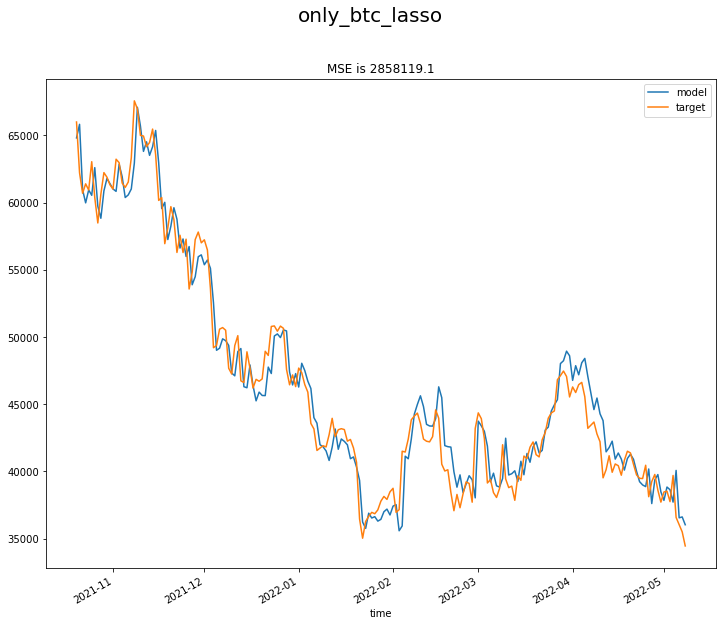

In [44]:
eval_model.visualize_plot(lasso_only_predict[-200:], y[-200:], name="only_btc_lasso")

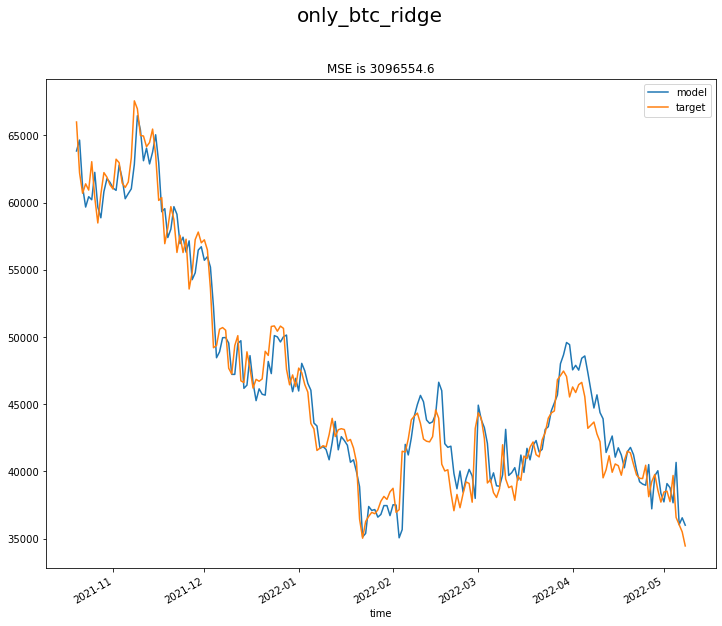

In [47]:
eval_model.visualize_plot(ridge_only_predict[-200:], y[-200:], name="only_btc_ridge")


비트코인 데이터로만 학습한 모델을 최적화 하자

In [48]:
def plot_bar(data, name):
    cnts = data.value_counts()
    cnts.sort_values(ascending=False,inplace=True)
    plt.figure(figsize=(12,8))
    plt.bar(cnts.index, cnts.values)
    plt.ylabel("Count")
    plt.xlabel("Error %")
    plt.xticks(range(-100,100,10))
    plt.title(name)
    plt.xlim(-100,100)

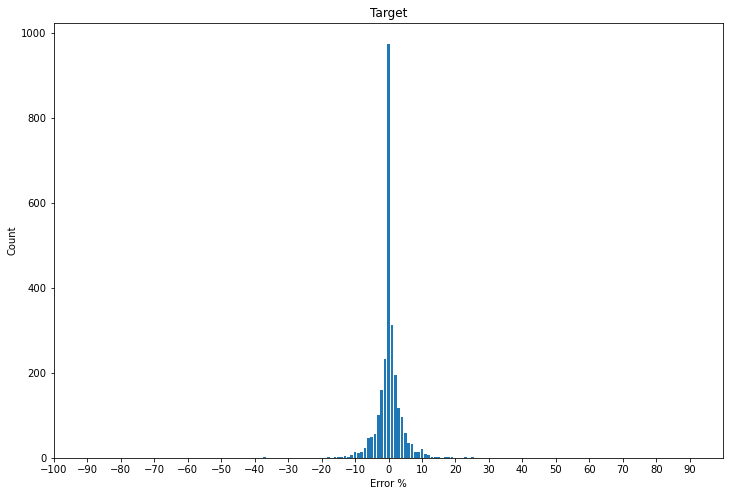

In [49]:
plot_bar(df['Pct'].astype(int), name="Target")

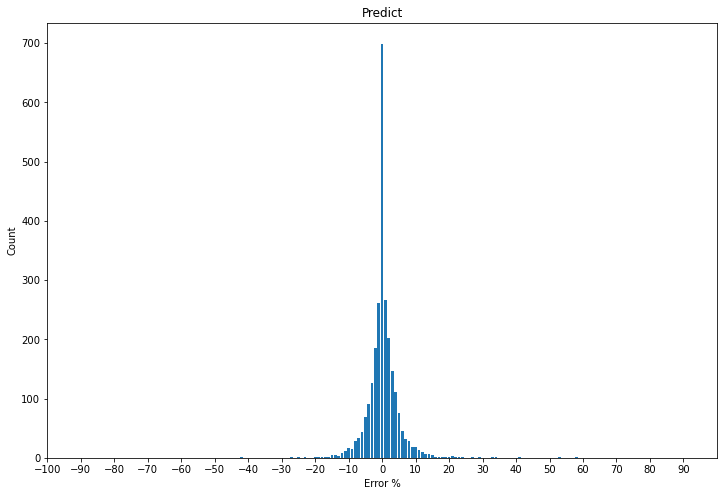

In [52]:
pred_pct = lasso_only_predict.pct_change().dropna() * 100
plot_bar(pred_pct.astype(int), name="Predict")

var: 48.97045825222123, mean: 1.0962850822795873


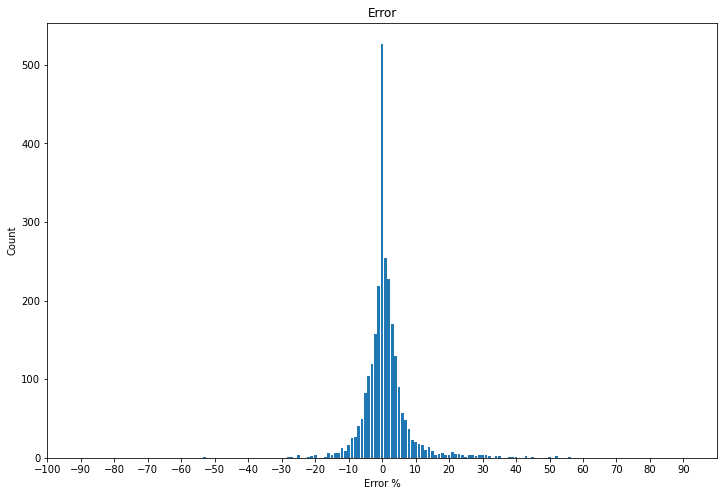

In [58]:
error = (y - lasso_only_predict) * 100 / y
error_mean = error.mean()
error_var = error.var()
error = error.astype(int)
print(f"var: {error_var}, mean: {error_mean}")
plot_bar(error,name="Error")


In [77]:
def get_thershold(pred_pct, X):
    for t in range(-5,5):
        pred_pct = pred_pct.round(2)
        price_pct = X['Pct'].iloc[1:] #y와 인덱스를 맞춰준다.
        true_pos = pred_pct[(pred_pct > t) & (price_pct > 0)] #모델이 상승세라 예측했고 실제로 상승한 날들
        false_pos = pred_pct[(pred_pct > t) & (price_pct <= 0)]
        true_neg = pred_pct[(pred_pct < t) & (price_pct < 0)]
        false_neg = pred_pct[(pred_pct < t) & (price_pct >= 0)]
        print("Threshold: ", t)
        print(f"true_pos: {len(true_pos)}, false_pos: {len(false_pos)}")
        print(f"true_neg: {len(true_neg)}, false_neg: {len(false_neg)}")
        precison = len(true_pos) / (len(true_pos) + len(false_pos))
        recall = len(true_pos) / (len(true_pos) + len(false_neg))
        f1 = (2 * precison * recall) / (precison + recall)
        print("Precision: ",precison)
        print("Recall: ",recall)
        print("F1: ", f1)

before_price = df['Price'].iloc[:-1]
pred_profit = 100 * (lasso_only_predict.values - before_price.values) / lasso_only_predict
get_thershold(pred_profit, X)
# get_thershold(pred_pct, X)
    

Threshold:  -5
true_pos: 1259, false_pos: 1082
true_neg: 116, false_neg: 167
Precision:  0.5378043571123452
Recall:  0.8828892005610098
F1:  0.6684364215556146
Threshold:  -4
true_pos: 1218, false_pos: 1047
true_neg: 151, false_neg: 208
Precision:  0.5377483443708609
Recall:  0.8541374474053296
F1:  0.6599837442427526
Threshold:  -3
true_pos: 1150, false_pos: 983
true_neg: 215, false_neg: 274
Precision:  0.5391467416783873
Recall:  0.8075842696629213
F1:  0.6466123137475401
Threshold:  -2
true_pos: 1031, false_pos: 875
true_neg: 321, false_neg: 395
Precision:  0.5409233997901364
Recall:  0.7230014025245441
F1:  0.6188475390156062
Threshold:  -1
true_pos: 878, false_pos: 740
true_neg: 456, false_neg: 549
Precision:  0.5426452410383189
Recall:  0.6152768044849334
F1:  0.5766830870279145
Threshold:  0
true_pos: 667, false_pos: 550
true_neg: 645, false_neg: 759
Precision:  0.5480690221857025
Recall:  0.46774193548387094
F1:  0.504729474082482
Threshold:  1
true_pos: 470, false_pos: 370
tru

In [78]:
pred_profit

time
2015-03-01    -5.232407
2015-03-02    -1.967180
2015-03-03     0.561153
2015-03-04   -13.361572
2015-03-05   -15.594961
                ...    
2022-05-04    -0.092098
2022-05-05     0.937325
2022-05-06    -0.073374
2022-05-07     1.562517
2022-05-08     1.470278
Length: 2625, dtype: float64

In [28]:
def get_profit(y, thereshold, days=0): #현재로 부터 과거 몇일의 수익
    buy_point = X[pred_pct.values > thereshold] #예측 값이 전날의 예측 값 대비 i%이상 상승하면 매수
    sell_point = []
    for i in buy_point.index:
        index = X.index.get_loc(i) + 1        #매수 다음 거래일에 바로 매도한다.
        if index < len(X):
            sell_point.append(index)
            
    sell_value = y.iloc[sell_point]

    profit = (sell_value.values - buy_point.values) / buy_point.values
    seed = 1 #처음 seed
    seed_record = [] #profit 저장용

    for p in profit[-days:]:
        seed = seed * (1 + p)
        seed_record.append(seed)
    return pd.Series(index=sell_value.index, data=seed_record)

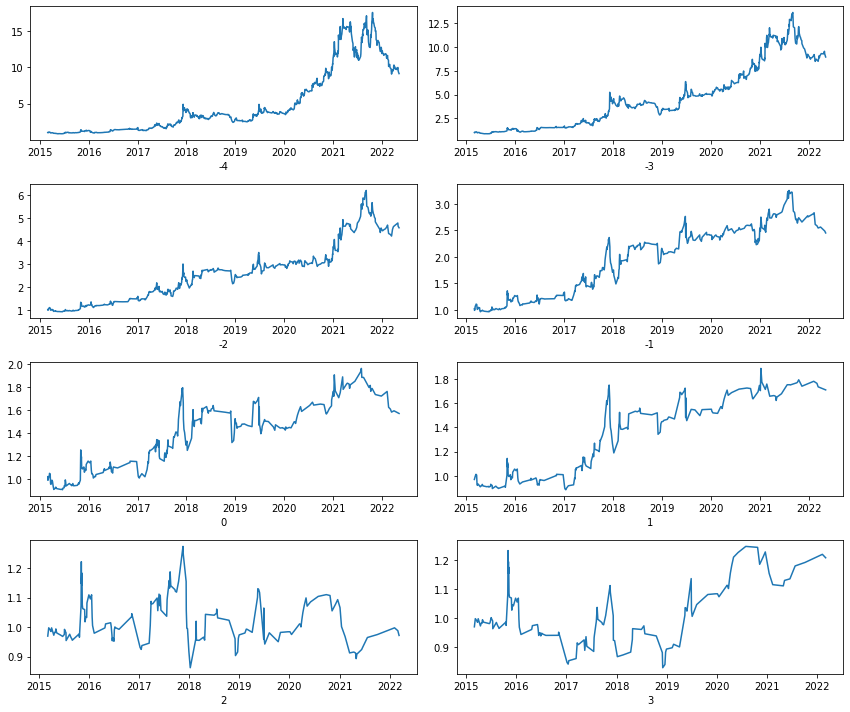

In [29]:
n_split = 8
start = -4
end = start + n_split
rows = lambda x: x//2 if x % 2 == 0 else x//2 + 1
fig, axes = plt.subplots(rows(n_split), 2, figsize=(12,10))
results = {}
for i, v in enumerate(range(start, end), start=1):
    profit = get_profit(y.iloc[1:], i)
    results[v] = profit
    plt.subplot(rows(n_split), 2, i)
    plt.plot(profit)
    plt.xlabel(v)
plt.tight_layout()

(19020.0, 19120.0)

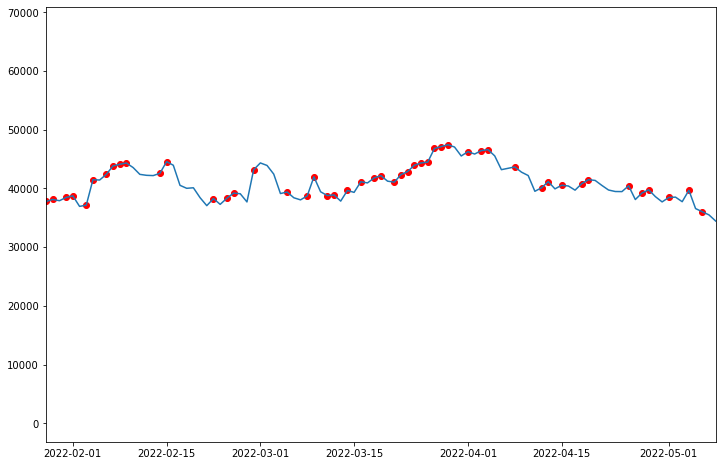

In [ ]:
buy_point = pred_pct[pred_pct > 0] 
buy_value = y[buy_point.index]
plt.figure(figsize=(12,8))
plt.plot(y)
plt.scatter(x=buy_point.index, y = buy_value, c='r')
plt.xlim(df.index[-100],df.index[-1])


In [ ]:
FIRST = 5
SECOND = 10
THIRD = 30

In [ ]:
momentum = {}
for k in results.keys():
    profit = results[k]
    short = profit.rolling(FIRST).apply(lambda x: x.prod() ** (1.0 / FIRST)) #2주 간의 기하 평균 수익률
    mid = profit / profit.rolling(SECOND).apply(lambda x: x.prod() ** (1.0 / SECOND)) #1달 간의 기하 평균 수익률
    long = profit / profit.rolling(THIRD).apply(lambda x: x.prod() ** (1.0 / THIRD)) #2달 간의 기하 평균 수익률
    momentum[k] = (short * 0.5 + mid * 0.3 + long * 0.2).dropna()

In [ ]:
momentum

{-4: time
 2015-05-04     450.446840
 2015-05-05     448.364043
 2015-05-09     445.566306
 2015-05-12     443.943433
 2015-05-13     439.497434
                  ...     
 2022-04-20    4895.761495
 2022-04-27    4905.707452
 2022-04-29    4899.763941
 2022-04-30    4855.999420
 2022-05-03    4809.966935
 Length: 984, dtype: float64,
 -3: time
 2015-05-09     462.874800
 2015-05-12     460.711577
 2015-05-13     458.326079
 2015-05-16     454.291910
 2015-05-21     451.311682
                  ...     
 2022-04-03    4551.976231
 2022-04-20    4592.869643
 2022-04-27    4638.279552
 2022-04-29    4653.181303
 2022-05-03    4642.478168
 Length: 717, dtype: float64,
 -2: time
 2015-06-10     467.581153
 2015-06-20     466.549437
 2015-06-21     465.604222
 2015-06-22     465.773024
 2015-06-25     467.464193
                  ...     
 2022-03-18    2176.087030
 2022-03-24    2204.046160
 2022-03-29    2239.909278
 2022-04-27    2297.161526
 2022-04-29    2320.982147
 Length: 515, dtype

In [ ]:
moment_df = pd.DataFrame(momentum[0]).fillna(0)
moment_df

,0
time,
2015-07-12,472.705296
2015-07-14,478.242244
2015-07-15,482.950097
2015-07-16,483.325086
2015-07-19,483.815883
...,...
2022-02-06,877.250084
2022-02-17,862.469006
2022-03-02,844.492717


In [ ]:
moment_df.max()

0    961.834701
dtype: float64